# Summary visualizations for the spectral libraries obtained from Patrick Lowrance

## Loading all necessary data

In [1]:
from retrieve_spectral_coverage import *
import itertools
import numpy as np
import pickle


CALSTAR_DIR = '/Users/berlinc/Downloads/calstar_templates'
# MISSION = 'targetList_HabEx_4m_coroOnly_DulzE_promo_EPRVmwants_lucky_charAsnr5_binMenn_20190929'
MISSION = 'targetList_HabEx_4m_LJSoC_DulzE_TV3_EPRVfalse_randluck_GA.0_binMenn_C1R140_a0.15b0c0.05d0e0.3f0.3_20190928b'



# Constants:
LETTER = ['O', 'B', 'A', 'F', 'G', 'K', 'M', 'L', 'T', 'Y']
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ROMAN = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII']

# Make a list of spectral types as a reference:
ref_st = []
for i in itertools.product(LETTER, NUMBER, ROMAN): 
    ref_st.append("".join(map(str, i)))

# Retrieve the target stars' spectral types corresponding to a mission simulation
with open(MISSION + '.pkl','rb') as f: target_spec_types = pickle.load(f)
for i, st in enumerate(target_spec_types):
    target_spec_types[i] = standerize_spec_type(st) # standerize_spec_type is from retrieve_spectral_coverage_utils

# Construct the corresponding 0.5-hot vector based on ref_st
targ_vect = np.zeros(len(ref_st))
mask = np.isin(np.array(ref_st), target_spec_types)
targ_vect[mask] = 0.5


# Get spectral coverages for engelke, current_calspec, cw_spectra, irs_cal, cohen
DATA = {}
DATA['engelke'] = getSpCov_engelke()
DATA['irs_cal'] = getSpCov_irs_cal()
DATA['current_calspec'] = getSpCov_calspec(CALSTAR_DIR + '/current_calspec')
DATA['cw_spectra'] = getSpCov_cw_spectra(CALSTAR_DIR + '/cw_spectra')
DATA['cohen'] = getSpCov_cohen(CALSTAR_DIR + '/cohen')
DATA['ck04models'] = getSpCov_ck04models('/Users/berlinc/Documents/exosims/EXOSIMS_fork/probing/spec_lib_summary/ckp00')
DATA['pickles'] = getSpCov_pickles()
DATA['bpgs'] = getSpCov_bpgs()

# Build df_input, which stores info comparing set of spec types from target list to 
#  set of spec types from the libraries:
df_input = {}
df_input['spec'] = ref_st
for lib in ['engelke', 'irs_cal', 'current_calspec', 'cw_spectra', 'cohen', 'ck04models', 'pickles', 'bpgs']:
    cov_vect = np.zeros(len(ref_st))
    mask = np.isin(np.array(ref_st), list(DATA[lib].keys()))
    # Convert the list to one-hot vectors based on the reference spectral-type list
    cov_vect[mask] = 1
    # Modify the lists based on target spectral types: 
    #  0:not covered/not needed, 0.5:not covered/needed, 1:covered/not needed, 1.5:covered/needed
    cov_vect = cov_vect + targ_vect
    cov_vect[cov_vect == 0] = np.nan
    df_input[lib] = cov_vect

/Users/berlinc/anaconda2/envs/es/lib/python3.6/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/berlinc/Documents/exosims/EXOSIMS_fork/probing/spec_lib_summary/trds/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Plot spectral type matchup

No handles with labels found to put in legend.


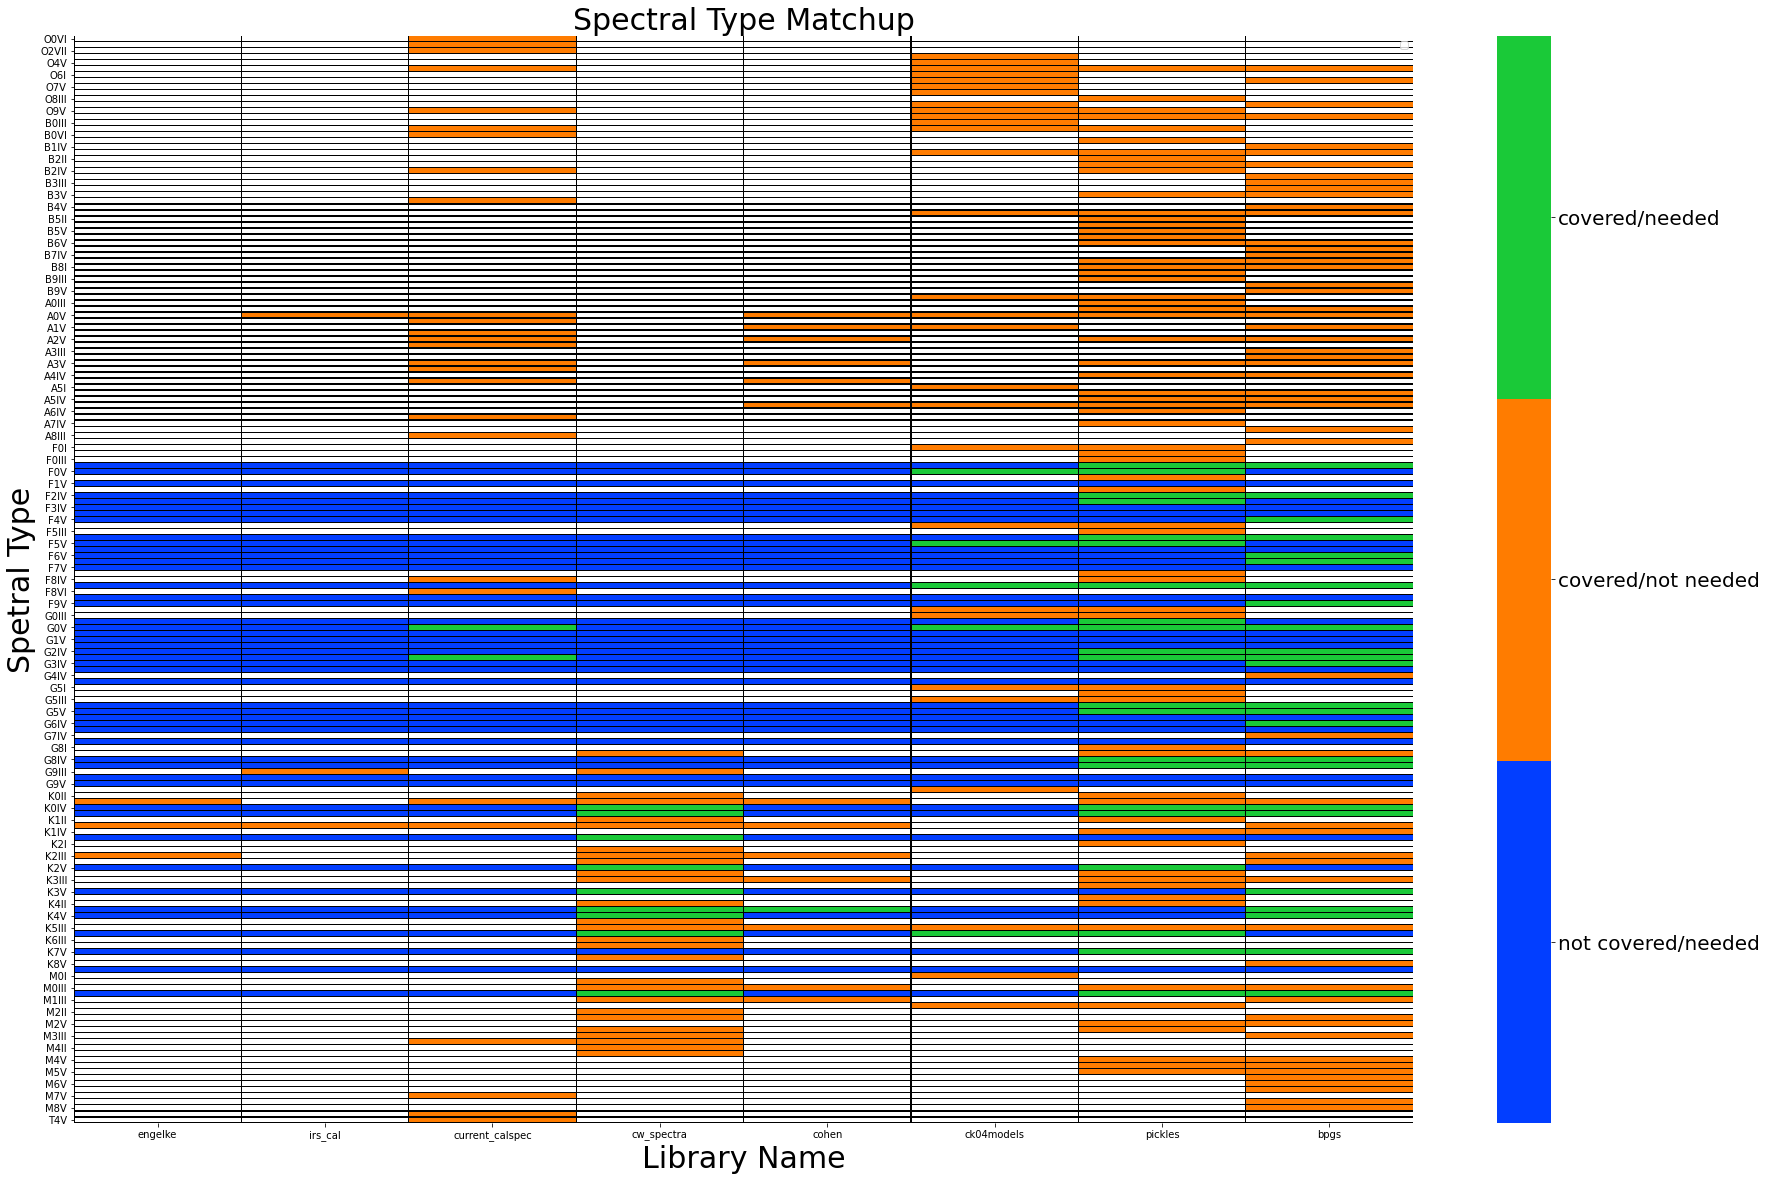

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 20))

# Create pandas dataframe:
df = pd.DataFrame(df_input)
df = df.set_index('spec')

# Plot/save heatmap with discrete colorscheme, following https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot

vmap = {0.5: 'not covered/needed', 1: 'covered/not needed', 1.5: 'covered/needed'}
n = 3
df = df.dropna(how='all')

cmap = sns.color_palette("bright", n)
ax = sns.heatmap(df, cmap=cmap, linewidths=.25, linecolor='black')

# Get the colorbar object from the Seaborn heatmap
colorbar = ax.collections[0].colorbar
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(list(vmap.values()))
for t in colorbar.ax.get_yticklabels():
     t.set_fontsize(20)

# Adjust aesthetics:
ax.title.set_text('Spectral Type Matchup')
ax.set_ylabel('Spetral Type')
ax.set_xlabel('Library Name')
ax.xaxis.label.set_fontsize(30)
ax.yaxis.label.set_fontsize(30)
ax.title.set_fontsize(30)
for item in ax.legend().get_texts():
    item.set_fontsize(20)

plt.savefig(MISSION + '.png', dpi=300)

## Plot wavelength range coverage

Construct all the necessary data objects:

In [3]:
# NOTE: We need spec_type_index_map, spec_type_filter_map, filtered_ref_st, and filtered_spec_type_indices 
#  because we want to compress the list of possible spectral types (in the y-axis of the plot) into only 
#  those found in spec_type_indices, otherwise there will be too many y values to visualize.

spec_type_index_map = {}
for i, rt in enumerate(ref_st):
    spec_type_index_map[rt] = i


dataset_indices = []
spec_type_indices = []
dataset_names = ['engelke', 'irs_cal', 'current_calspec', 'cw_spectra', 'cohen', 'ck04models', 'pickles', 'bpgs']
intervals = []
for di, dataset in enumerate(dataset_names):
    for spec_type in DATA[dataset].keys():
        dataset_indices.append(di)
        spec_type_indices.append(spec_type_index_map[spec_type])
        intervals.append(DATA[dataset][spec_type])
    
    
spec_type_filter_map = {}
filtered_ref_st = []
i = 0
for st_i in sorted(spec_type_indices):
    if st_i in spec_type_filter_map:
        continue
    spec_type_filter_map[st_i] = i
    filtered_ref_st.append(ref_st[st_i])
    i += 1

    
filtered_spec_type_indices = []
for st_i in spec_type_indices:
    filtered_spec_type_indices.append(spec_type_filter_map[st_i])

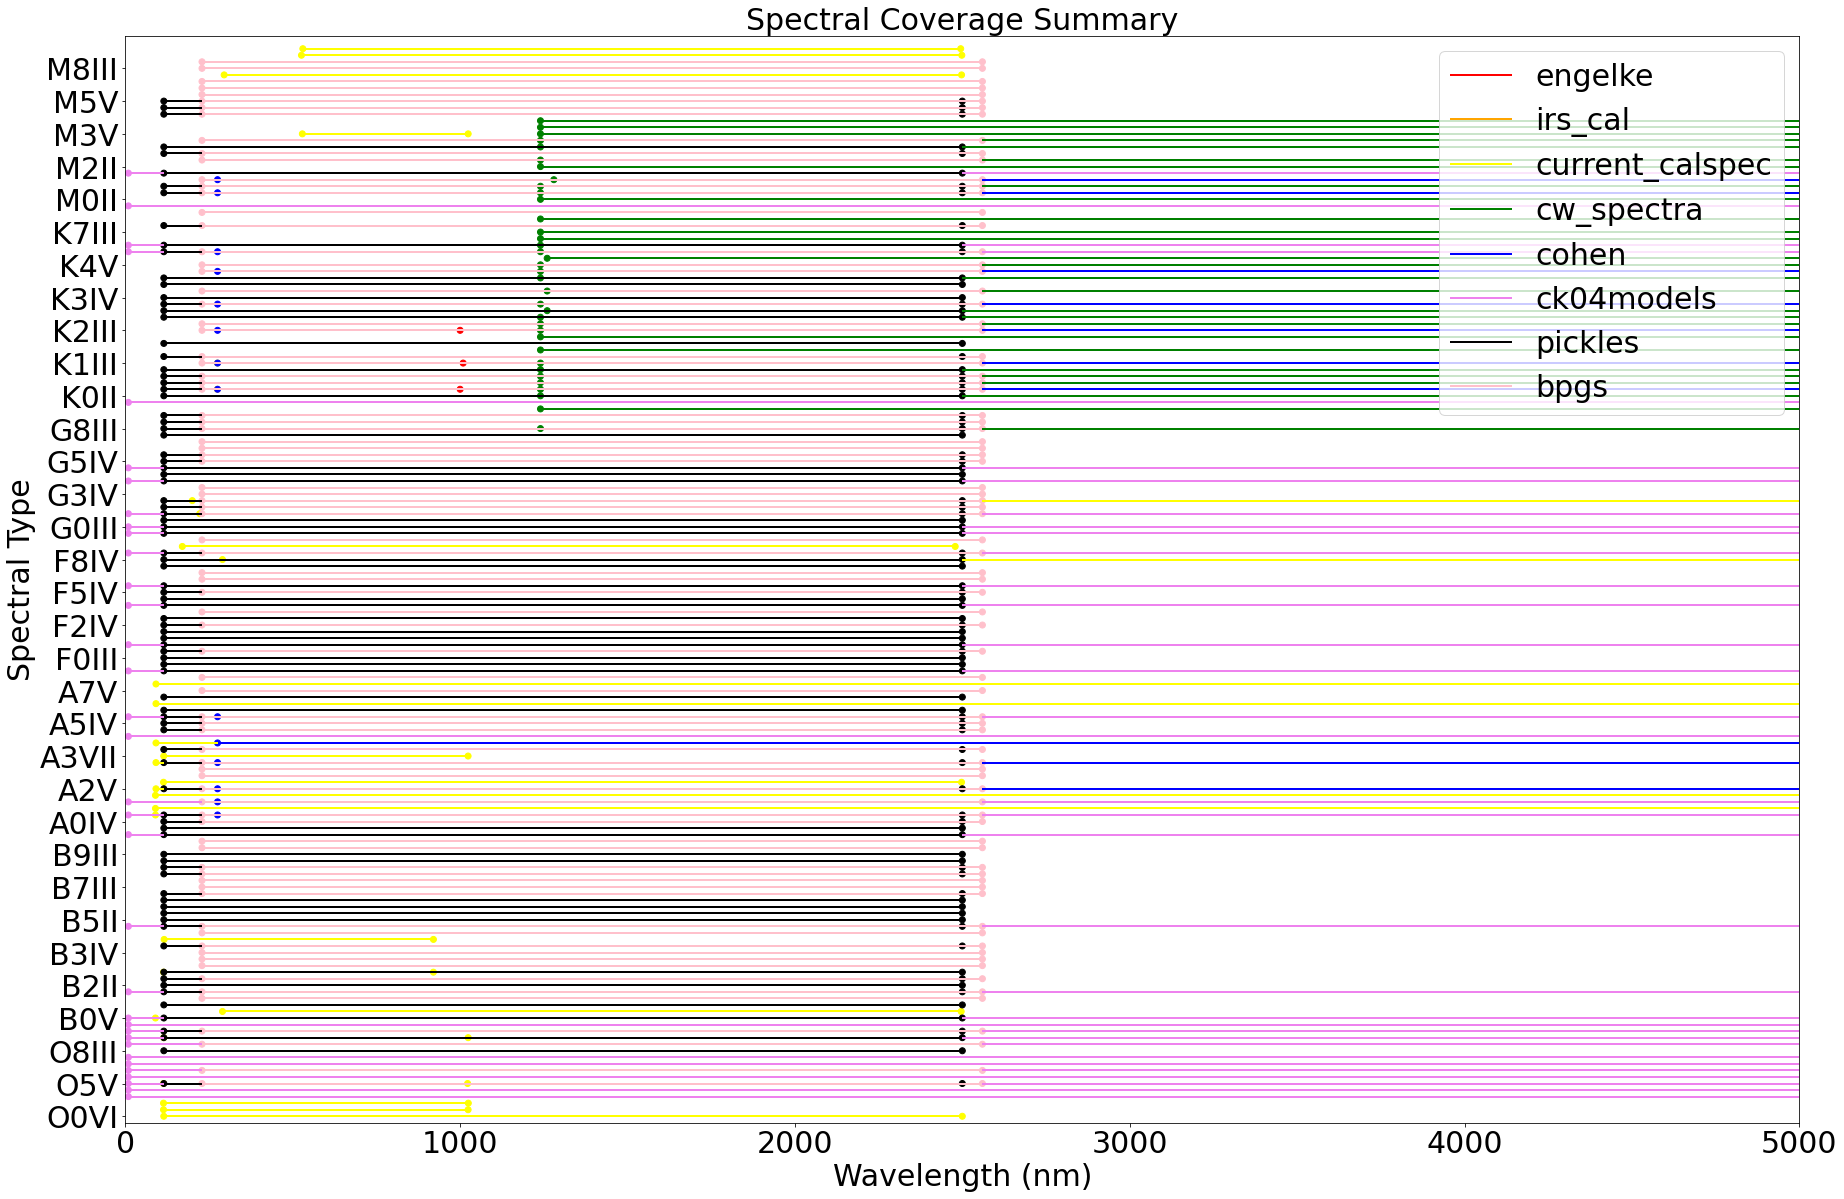

In [4]:
# Plot coverage as a function of spectral type:
#  (some code taken from stackoverflow.com/questions/56584939/matplotlibs-build-in-interval-plot)

from matplotlib.lines import Line2D # Imported for legends
import numpy as np
from matplotlib import collections  as mc
import matplotlib.pyplot as plt


ANNOT = False # Whether to annotate the ranges (Warning: if True then an error will be encountered but we
                # still obtain the desired .png image inspite of the error)

num_datasets = len(dataset_names)
unique_colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet', 'black', 'pink']
colors = np.array([unique_colors[idx] for idx in dataset_indices])

# viridis = plt.cm.get_cmap('viridis', len(dataset_names))
# unique_colors = np.array([viridis(idx / num_datasets) for idx in np.arange(len(dataset_names)) + 1])
# colors = np.array([viridis(idx / num_datasets) for idx in np.array(dataset_indices) + 1])


# Prepare the input data in correct format for LineCollection 
lines = [[(i[0], j), (i[1], j)] for i, j in zip(intervals, filtered_spec_type_indices)]#range(len(intervals)))]

lc = mc.LineCollection(lines, colors= colors, linewidths=2)
fig, ax = plt.subplots(figsize=(30, 20))#figsize=(50, 30))
ax.add_collection(lc)
ax.margins(0.1)
# plt.yticks(range(len(filtered_ref_st)), filtered_ref_st)
plt.yticks(range(0, len(filtered_ref_st), 5), filtered_ref_st[::5])

ax.tick_params(axis='both', which='major', labelsize=30)

# Adding the legends
def make_proxy(col, scalar_mappable, **kwargs):
    color = col 
    return Line2D([0, 1], [0, 1], color=color, **kwargs)
proxies = [make_proxy(c, lc, linewidth=2) for c in unique_colors]

ax.legend(proxies, dataset_names, fontsize=30)

# Adding annotations
if ANNOT:
    for i, x, c in zip(filtered_spec_type_indices, intervals, range(len(spec_type_indices))):
        plt.text(x[0], i+0.1, x[0], color=colors[c])
        plt.text(x[1], i+0.1, x[1], color=colors[c])
    
#Add dots to the end of lines:
x = [i[0] for j in lines for i in j]
y = [i[1] for j in lines for i in j]
c = [col for col in colors for _ in (0, 1)]

ax.scatter(x, y, c=c)

#NOTE: restricting x limits makes the displayed plot tiny in Jupyterhub, so see the saved png.
ax.set_xlim([0, 5000]) 
ax.set_ylim([-1, len(filtered_ref_st) + 1])

ax.set_title('Spectral Coverage Summary', fontsize=30)
ax.set_xlabel('Wavelength (nm)', fontsize=30)
ax.set_ylabel('Spectral Type', fontsize=30)

if ANNOT:
    plt.savefig('spectral_coverage_barplot_annot.png')
else:
    plt.savefig('spectral_coverage_barplot.png')

In [5]:
# Prints numerical summary:

print(MISSION[11:80] + '... :')
unique_target_spec_types = list(set(target_spec_types))
print(' There are ' + str(len(unique_target_spec_types)) + ' target spectral types.')
print(' Of those:')
for lib in ['engelke', 'irs_cal', 'current_calspec', 'cw_spectra', 'cohen', 'ck04models', 'pickles']:
    tmp = df_input[lib]
    tmp = tmp[~np.isnan(tmp)]
    unique, counts = np.unique(tmp, return_counts=True)
    counter = dict(zip(unique, counts))
    if 1.5 not in counter: counter[1.5] = 0 
    print('  ' + str(counter[1.5]) + ' are covered by ' + lib + ', which has ' \
      + str(counter[1] + counter[1.5]) + ' spectral types.')

HabEx_4m_LJSoC_DulzE_TV3_EPRVfalse_randluck_GA.0_binMenn_C1R140_a0.15... :
 There are 48 target spectral types.
 Of those:
  0 are covered by engelke, which has 3 spectral types.
  0 are covered by irs_cal, which has 3 spectral types.
  2 are covered by current_calspec, which has 29 spectral types.
  9 are covered by cw_spectra, which has 36 spectral types.
  1 are covered by cohen, which has 14 spectral types.
  5 are covered by ck04models, which has 34 spectral types.
  21 are covered by pickles, which has 88 spectral types.


In [6]:
# Prints numerical summery of coverage:

import pandas as pd

pd.set_option('display.max_rows', None)

spec_type, min_spec, max_spec = [], [], []
d = DATA['cohen']

for k in d.keys():
    spec_type.append(k)
    min_spec.append(d[k][0])
    max_spec.append(d[k][1])
    
df = pd.DataFrame({'Spectral Type': spec_type, 'Min wavelength (nm)': min_spec, 'Max wavelength (nm)': max_spec})
df = df.set_index('Spectral Type')
print(df.head())

               Min wavelength (nm)  Max wavelength (nm)
Spectral Type                                          
K2III                        275.5              35000.0
K3III                        275.5              35000.0
A0V                          275.5              40000.0
K0III                        275.5              35000.0
A3V                          275.5              40000.0


## Visualizing individual spectrum (before renormalization)

`cw_spectra`:

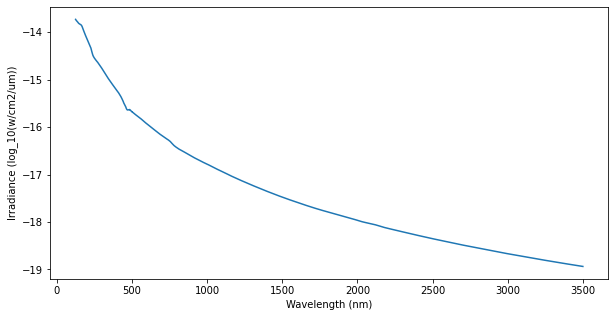

In [7]:
import matplotlib.pyplot as plt
import numpy as np

FILE = '/Users/berlinc/Downloads/calstar_templates/cw_spectra/templates/hd77996.tem'

wavelength, irrad = get_spectra_from_tem_dlv(FILE)

wavelength = [i * 100 for i in wavelength]
irrad = [np.log10(i) for i in irrad]

plt.figure(figsize=(10, 5))
plt.plot(wavelength, irrad)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance (log_10(w/cm2/um))')
plt.show()

`cohen`:

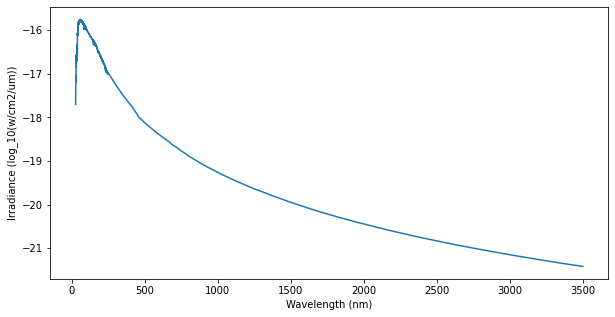

In [8]:
import matplotlib.pyplot as plt
import numpy as np

FILE = '/Users/berlinc/Downloads/calstar_templates/cohen/SA103_526.tem'

wavelength, irrad = get_spectra_from_tem_dlv(FILE)

wavelength = [i * 100 for i in wavelength]
irrad = [np.log10(i) for i in irrad]

plt.figure(figsize=(10, 5))
plt.plot(wavelength, irrad)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance (log_10(w/cm2/um))')
plt.show()

`current_calspec`:

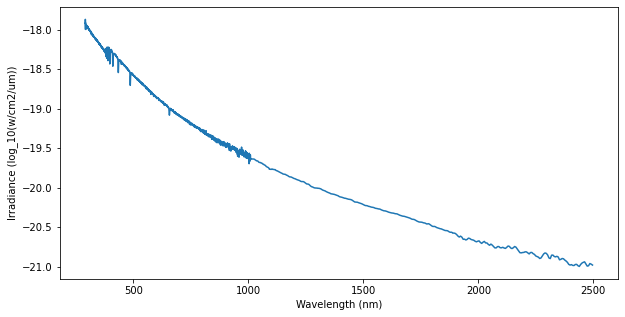

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

FILE = '/Users/berlinc/Downloads/calstar_templates/current_calspec/snap1_stisnic_003.fits'

with fits.open(FILE) as hdulist:
    sdat = hdulist[1].data

wavelength, irrad = sdat.WAVELENGTH/10, sdat.FLUX

# FLUX was in erg s-1 cm-2 A-1
irrad = [np.log10(i*1e-4) for i in irrad]

plt.figure(figsize=(10, 5))
plt.plot(wavelength, irrad)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance (log_10(w/cm2/um))')
plt.show()

`ck04models`:

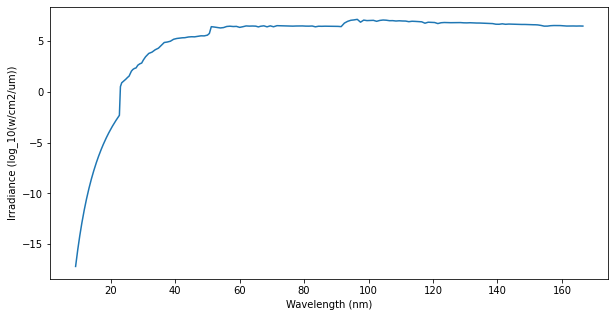

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

FILE = 'ckp00/ckp00_35000.fits'
CAP = 200

with fits.open(FILE) as hdulist:
    sdat = hdulist[1].data

wavelength, irrad = sdat.WAVELENGTH/10, sdat.g45

# FLUX was in erg s-1 cm-2 A-1
irrad = [np.log10(i*1e-4) for i in irrad]

plt.figure(figsize=(10, 5))
plt.plot(wavelength[:CAP], irrad[:CAP])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance (log_10(w/cm2/um))')
plt.show()

The other two libraries (`irs_cal` and `engelke`) are small so I inspected the spectra files by just looking at their content.

## Visualizing spectra with same spectral types

We first estimate which spectral type is the most popular. Note that the numbers correspond to the number of unique stars, _not_ the number of spectra files in calstar_templates.

In [11]:
from collections import Counter
from retrieve_spectral_coverage import *

spec_type_map = load_spec_type_map_from_csv()
spec_type_dist = spec_type_map.values()
spec_type_dist = [standerize_spec_type(v) for v in spec_type_map.values()]
c = Counter(spec_type_dist)
c.most_common(3)

[('K5III', 106), ('M0III', 77), ('K3III', 76)]

Given a spectral type, we now visualize all spectra in calstar_templates, given a spectral type, and renormalized it so that it is 0 vegamag in the Johnson K band:

91 files have spectral type K5III (after standardization).
/Users/berlinc/Downloads/calstar_templates/cohen/templates/HD189695.tem skipped.
/Users/berlinc/Downloads/calstar_templates/cohen/templates/HD59381.tem skipped.
/Users/berlinc/Downloads/calstar_templates/cohen/templates/HD45018.tem skipped.
/Users/berlinc/Downloads/calstar_templates/cohen/templates/HD99167.tem skipped.
/Users/berlinc/Downloads/calstar_templates/cohen/templates/HD193579.tem skipped.
/Users/berlinc/Downloads/calstar_templates/cohen/templates/HD39853.tem skipped.
/Users/berlinc/Downloads/calstar_templates/cohen/templates/HD95212.tem skipped.
/Users/berlinc/Downloads/calstar_templates/cohen/templates/HD224630.tem skipped.
/Users/berlinc/Downloads/calstar_templates/cohen/templates/HD151217.tem skipped.
/Users/berlinc/Downloads/calstar_templates/cohen/templates/HD218452.tem skipped.
/Users/berlinc/Downloads/calstar_templates/cohen/templates/HD102461.tem skipped.
/Users/berlinc/Downloads/calstar_templates/cohen/templa

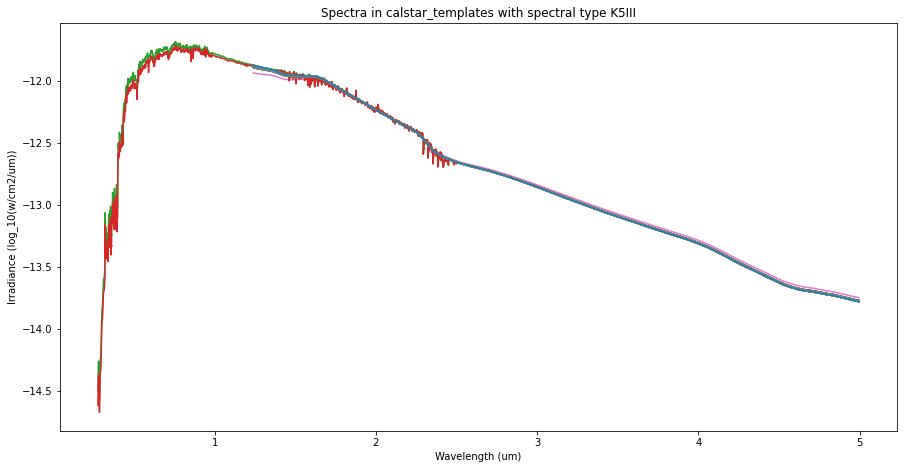

In [4]:
#export PYSYN_CDBS=/Users/berlinc/Documents/exosims/EXOSIMS_fork/probing/spec_lib_summary/trds/
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from retrieve_spectral_coverage import * 
from astropy import units as u 

CALSTAR_DIR = '/Users/berlinc/Downloads/calstar_templates'
SPEC_TYPE= 'K5III'
LOG = True
MAX_L = 5 #float('inf') # in um
renorm_band = 'johnson,k'

files = retrieve_files_from_spec_type(SPEC_TYPE, CALSTAR_DIR)
reduced_files = [ f for f in files if 'cohen/templates/' not in f]

print(str(len(reduced_files)) + ' files have spectral type ' + SPEC_TYPE + ' (after standardization).')

plt.figure(figsize=(15, 7.5))

for file in files:
    if 'cohen/templates/' in file:
        print(file +' skipped.')
        continue
    if '.tem' in file or '.dlv' in file: # cw_spectra or cohen
        wavelength, irrad = get_spectra_from_tem_dlv(file)
        
        # Converting um to nm
        wavelength = np.array(wavelength) * u.um
        irrad = np.array(irrad) * u.W /(u.cm)**2 /u.um
        
    elif '.fits' in file: # curr_calspec
        with fits.open(file) as hdulist:
            sdat = hdulist[1].data
        wavelength, irrad = sdat.WAVELENGTH, sdat.FLUX 
        wavelength = wavelength * u.AA
        irrad = irrad *u.erg/u.s/(u.cm)**2/u.AA

    elif '.txt' in file: # irs_cal
        wavelength, irrad = get_spectra_from_ascii(file)
 
        # Converting um to nm
        wavelength = np.array(wavelength) * u.um

        # Converting js to W cm-2 um-1:
        irrad = np.array(irrad) *u.Jy
        irrad = irrad.to(u.W /(u.cm)**2 /u.um, equivalencies=u.spectral_density(wavelength))
    elif '.dat' in file: # engelke
        wavelength, irrad = get_spectra_from_ascii(file)
        
        # Converting um to nm
        wavelength = np.array(wavelength) * u.um
        irrad = np.array(irrad) * u.W /(u.cm)**2 /u.um
    else:
        print('File ' + file + ' cannot be found!')
        continue
    if wavelength[0].value > 2:
            print(file + ' starts from >2 um')
    try:
        wavelength, irrad = renormalize_spectra(wavelength, irrad, renorm_band)
    except:
        print(file + ' failed to renormalize')
        continue
    wavelength = wavelength.to(u.um)
    irrad = irrad.to(u.W /(u.cm)**2 /u.um)


    
    if LOG:
        irrad = [np.log10(i.value) for i in irrad]

    wavelength = np.array(wavelength)
    irrad = np.array(irrad)
    plt.plot(wavelength[wavelength < MAX_L], irrad[wavelength < MAX_L])

plt.xlabel('Wavelength (um)')
log = 'log_10' if LOG else ''
plt.ylabel('Irradiance (' + log + '(w/cm2/um))')
plt.title('Spectra in calstar_templates with spectral type ' + SPEC_TYPE)
log = '_log10' if LOG else ''
plt.savefig('calstar_st_' + SPEC_TYPE + log + '.png')